# Cleaning Effects on Distributions

This notebook briefly analyses the effects of the cleaning pipelines on distributions in the Airbnb data.

In [1]:
import pandas as pd
import itertools
import numpy as np
from cleaner import ErrorCleaner
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import jensenshannon
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Price distribution

The following code highlights how the cleaning pipelines can affect the target ('Price') variable's distribution.

In [2]:
airbnb_data = pd.read_csv('airbnb_raw.csv')

mv_repair_methods = ['delete', 'mean-mode', 'median-mode', 'mode-mode']

outlier_detection_methods = ['none', 'SD', 'IQR']
outlier_repair_methods = ['mean', 'median', 'mode']

duplicate_repair_methods = ['NA', 'key_val']

training_list = [mv_repair_methods, outlier_detection_methods, outlier_repair_methods, duplicate_repair_methods]
training_combinations = [p for p in itertools.product(*training_list)]

cleaning_setups_df = pd.DataFrame(training_combinations, columns =['mv_repair', 'outlier_detection', 'outlier_repair', 
                'duplicate_repair'])

cleaning_setups_df['outlier_repair'].mask(cleaning_setups_df['outlier_detection'] == 'none', 'NA', inplace=True)

cleaning_setups_df = cleaning_setups_df.drop_duplicates()

cleaning_setups_df = cleaning_setups_df.reset_index()
cleaning_setups_df = cleaning_setups_df.drop(['index'], axis = 1)

airbnb_data_subset = airbnb_data[['Price', 'latitude', 'longitude']]

all_cleaned_dfs = pd.DataFrame(columns = list(cleaning_setups_df.columns) + ['dataset'])

for j in range(len(cleaning_setups_df)):
    cleaning_setup = cleaning_setups_df.loc[j]

    error_cleaner = ErrorCleaner(airbnb_data_subset, cleaning_setup)
    cleaned_dataset = error_cleaner.clean_all(['latitude', 'longitude'])

    cleaned_df = dict(cleaning_setup)
    cleaned_df['dataset'] = cleaned_dataset
    
    all_cleaned_dfs = all_cleaned_dfs.append(cleaned_df, ignore_index = True)

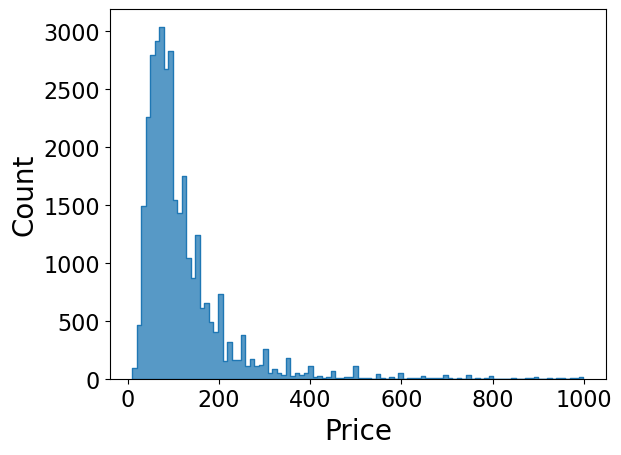

In [3]:
# MVs deleted, outliers and duplicates unaddressed
ax = sns.histplot(all_cleaned_dfs.dataset.loc[0].Price.values, bins = 100, element = 'step')
ax.set(xlabel='Price', ylabel='Count')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', labelsize=16)
plt.show()

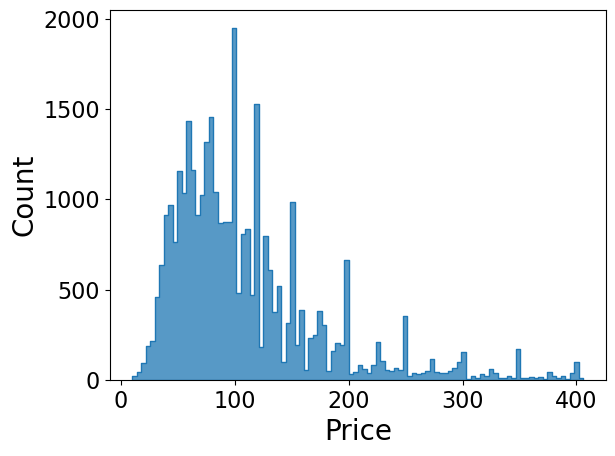

In [4]:
# missing values filled with mean, outliers detected using standard deviation and replaced with mean, duplicates unaddressed
ax = sns.histplot(all_cleaned_dfs.dataset.loc[16].Price.values, bins = 100, element = 'step')
ax.set(xlabel='Price', ylabel='Count')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', labelsize=16)
plt.show()

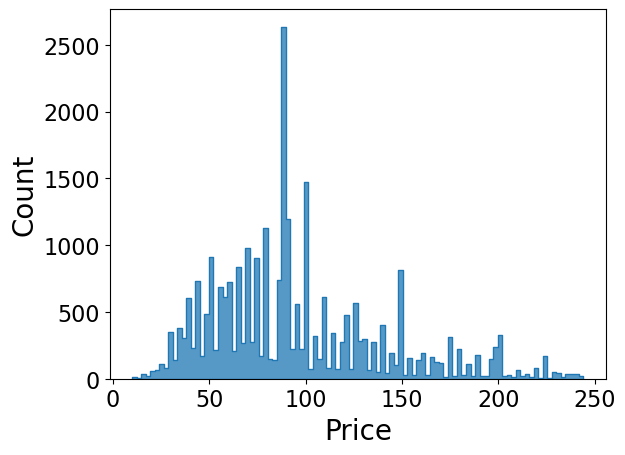

In [5]:
# MVs replaced with median, outliers detected with IQR and replaced with median, duplicates deleted
ax = sns.histplot(all_cleaned_dfs.dataset.loc[39].Price.values, bins = 100, element = 'step')
ax.set(xlabel='Price', ylabel='Count')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='both', labelsize=16)
plt.show()

## Differences in Distributions

The following code shows the differences in variable distributions (based on Jensen Shannon distance) that can arise through different training and test cleaning pipelines.

In [6]:
def dist_calc(columns, training_df, test_df):
    dist_dic = {}
    for column in columns:
        training_vals = training_df[column].values
        test_vals = test_df[column].values

        testing_dist,bins_numpy = np.histogram(test_vals,bins=100)
        training_dist,bins2 = np.histogram(training_vals,bins=bins_numpy)
    
        js_dist = jensenshannon(testing_dist,training_dist)

        dist_dic = dist_dic | {column:js_dist}
    return dist_dic

In [7]:
columns_to_test = ['Price', 'NumReviews', 'cost_living_index (US avg. = 100)']

In [ ]:
distribution_distances_df = pd.DataFrame(columns=['train_test_split', 'training_pipeline', 'test_pipeline'] + columns_to_test)

for train_test_split in range(20):
    all_training_data = pd.read_pickle('airbnb_cleaned_train_df_' + str(train_test_split) + '.pkl')
    all_testing_data = pd.read_pickle('airbnb_cleaned_test_df_' + str(train_test_split) + '.pkl')

    for i in range(len(all_training_data)):
        training_df = all_training_data.dataset.loc[i]
        
        for j in range(len(all_testing_data)):
            test_df = all_testing_data.dataset.loc[j]
        
            dist_dict = dist_calc(columns_to_test, training_df, test_df)

            distribution_distances_df = distribution_distances_df.append({'train_test_split': train_test_split, 
                                                                          'training_pipeline': i, 'test_pipeline': j} | dist_dict,
                                                                         ignore_index=True)

In [8]:
#distribution_distances_df.to_csv('cleaning_effects_distributions.csv')
distribution_distances_df = pd.read_csv('cleaning_effects_distributions.csv')

In [9]:
distribution_distances_df['average_dist'] = distribution_distances_df[['Price', 'NumReviews', 'cost_living_index (US avg. = 100)']].mean(axis=1)
distribution_distances_df = distribution_distances_df.groupby(['training_pipeline', 'test_pipeline']).mean().reset_index()
distribution_distances_df = distribution_distances_df.drop(['train_test_split'], axis = 1)

#### Training cleaning pipelines that minimise distribution differences:

In [10]:
# using target variable only
distribution_distances_df.groupby(['training_pipeline']).mean().sort_values('Price')

,test_pipeline,Unnamed: 0,Price,NumReviews,cost_living_index (US avg. = 100),average_dist
training_pipeline,,,,,,
73.0,48.5,98440.5,0.052729,0.045094,0.066100,0.054641
31.0,48.5,94324.5,0.052729,0.045094,0.066100,0.054641
29.0,48.5,94128.5,0.053200,0.043810,0.066100,0.054370
71.0,48.5,98244.5,0.053200,0.043810,0.066100,0.054370
47.0,48.5,95892.5,0.053272,0.044996,0.065666,0.054645
...,...,...,...,...,...,...
54.0,48.5,96578.5,0.081458,0.057312,0.057409,0.065393
65.0,48.5,97656.5,0.091783,0.082905,0.066147,0.080278
23.0,48.5,93540.5,0.091783,0.082905,0.066147,0.080278


In [11]:
# using target plus features
distribution_distances_df.groupby(['training_pipeline']).mean().sort_values('average_dist')

,test_pipeline,Unnamed: 0,Price,NumReviews,cost_living_index (US avg. = 100),average_dist
training_pipeline,,,,,,
28.0,48.5,94030.5,0.053399,0.044979,0.057010,0.051796
70.0,48.5,98146.5,0.053399,0.044979,0.057010,0.051796
30.0,48.5,94226.5,0.053461,0.046094,0.057010,0.052188
72.0,48.5,98342.5,0.053461,0.046094,0.057010,0.052188
60.0,48.5,97166.5,0.054699,0.045162,0.057101,0.052321
...,...,...,...,...,...,...
13.0,48.5,92560.5,0.067089,0.054084,0.146629,0.089267
10.0,48.5,92266.5,0.065015,0.062411,0.145852,0.091093
11.0,48.5,92364.5,0.066211,0.062254,0.146629,0.091698


#### Best training pipelines for given test pipeline:

In [12]:
# using target variable only
best_training = distribution_distances_df.loc[distribution_distances_df.groupby('test_pipeline').Price.idxmin()]

In [13]:
best_training.loc[best_training.training_pipeline == best_training.test_pipeline]

,training_pipeline,test_pipeline,Unnamed: 0,Price,NumReviews,cost_living_index (US avg. = 100),average_dist
99,1.0,1.0,91337.0,0.046999,0.041592,0.050523,0.046371
495,5.0,5.0,91733.0,0.047498,0.042633,0.050523,0.046885
1386,14.0,14.0,92624.0,0.045587,0.040040,0.036570,0.040732
1485,15.0,15.0,92723.0,0.044737,0.038326,0.043962,0.042342
1881,19.0,19.0,93119.0,0.045156,0.039479,0.043962,0.042866
2772,28.0,28.0,94010.0,0.043190,0.039360,0.036591,0.039714
2871,29.0,29.0,94109.0,0.042786,0.037727,0.043969,0.041494
3267,33.0,33.0,94505.0,0.042993,0.038598,0.043969,0.041853
4158,42.0,42.0,95396.0,0.043112,0.039409,0.036552,0.039691
4257,43.0,43.0,95495.0,0.042675,0.037739,0.043866,0.041427


In [14]:
np.unique(best_training.training_pipeline.values)

array([ 0.,  1.,  2.,  3.,  5., 14., 15., 16., 18., 19., 20., 28., 29.,
       30., 32., 33., 42., 43., 44., 46., 47., 48.])

In [15]:
len(np.unique(best_training.training_pipeline.values))

22

In [16]:
# using target plus features
best_training = distribution_distances_df.loc[distribution_distances_df.groupby('test_pipeline').average_dist.idxmin()]

In [17]:
best_training.loc[best_training.training_pipeline == best_training.test_pipeline]

,training_pipeline,test_pipeline,Unnamed: 0,Price,NumReviews,cost_living_index (US avg. = 100),average_dist
0,0.0,0.0,91238.0,0.047845,0.043623,0.043255,0.044908
1386,14.0,14.0,92624.0,0.045587,0.040040,0.036570,0.040732
2772,28.0,28.0,94010.0,0.043190,0.039360,0.036591,0.039714
4158,42.0,42.0,95396.0,0.043112,0.039409,0.036552,0.039691


In [18]:
np.unique(best_training.training_pipeline.values)

array([ 0.,  2.,  4.,  6., 14., 16., 18., 20., 28., 30., 32., 34., 42.,
       44., 46., 48.])

In [19]:
len(np.unique(best_training.training_pipeline.values))

16